I intend to use the MIMIC-IV critical care database to develop a machine learning model that predicts whether a patient discharged from the ICU is likely to be readmitted within 30 days during the same hospital stay.
In addition to standard predictive modeling, I will incorporate uncertainty quantification techniques to estimate the confidence of each prediction, ensuring that the model not only provides an outcome but also a measure of reliability. This is important for clinical decision support, where the trustworthiness of a prediction can influence real-world use. The project will also use SHAP analysis to interpret which features most influence model predictions.
The work will be carried out as an independent research project for skill development in healthcare data science and will not involve any interaction with human subjects.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
df=pd.read_csv("/content/mimiciv_queried_dataset.csv")
df["readmitted_within_30_days"].value_counts(normalize=True)
# len(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53689 entries, 0 to 53688
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   subject_id                 53689 non-null  int64  
 1   hadm_id                    53689 non-null  int64  
 2   stay_id                    53689 non-null  int64  
 3   admission_age              53689 non-null  int64  
 4   gender                     53689 non-null  object 
 5   race                       53689 non-null  object 
 6   language                   53541 non-null  object 
 7   marital_status             49573 non-null  object 
 8   los_hospital               53689 non-null  int64  
 9   los_icu                    53683 non-null  float64
 10  hospital_expire_flag       53689 non-null  int64  
 11  first_hosp_stay            53689 non-null  bool   
 12  first_icu_stay             53689 non-null  bool   
 13  comorbidity_score          53689 non-null  int

subject_id → unique patient ID (same patient may have multiple admissions)

hadm_id → unique hospital admission ID (each hospital stay)

stay_id → unique ICU stay ID (a patient can have multiple ICU stays in one hospital admission)

admission_age → patient’s age at hospital admission (in years)

gender → M/F/other

race → patient’s self-reported race

language → primary language

marital_status → single/married/etc.

los_hospital → length of stay in hospital (in days)

los_icu → length of stay in ICU (in days, can be fractional)

hospital_expire_flag → 1 if patient died during hospital stay, 0 if alive

first_hosp_stay → True/False — whether this was their first hospital stay in MIMIC record

first_icu_stay → True/False — whether this was their first ICU stay in MIMIC record

comorbidity_score → Charlson Comorbidity Index (higher = more severe comorbidities)

admittime → hospital admission date/time

dischtime → hospital discharge date/time
(For patient privacy, the admit and discharge dates in the MIMIC datset are shifted by a random offset for each patient.
The offsets preserve temporal consistency within a patient..so their admit/discharge order makes sense, but they don’t correspond to real-world years.)

readmitted_within_30_days → target variable (1 = yes, 0 = no)

main_diagnosis → grouped first diagnosis category (cardiovascular, respiratory, etc.)

In [3]:
df[df["language"].isnull()]
lang_freq=df["language"].value_counts()
cutoff_count=0.005* len(df)
categories_to_keep=lang_freq[lang_freq>=cutoff_count].index
df["language"]=df["language"].where(df["language"].isin(categories_to_keep), "Others")
df["language"]=df["language"].fillna("Others")
df["language"].value_counts()
# Keep only top 4 most frequent races, replace others with 'OTHER'
top_races = df["race"].value_counts().nlargest(4).index
df["race"] = df["race"].where(df["race"].isin(top_races), other="OTHER")

print(df["race"].value_counts())
print(df["readmitted_within_30_days"].value_counts(normalize=True))

race
WHITE                     32517
OTHER                     11002
BLACK/AFRICAN AMERICAN     5615
UNKNOWN                    4555
Name: count, dtype: int64
readmitted_within_30_days
0    0.9382
1    0.0618
Name: proportion, dtype: float64


In [4]:
# df[df["marital_status"].isnull()]
df["marital_status"]=df["marital_status"].fillna("UNKNOWN")
df["marital_status"].value_counts()
# df['marital_status'].unique()


,count
marital_status,
MARRIED,23472
SINGLE,19819
DIVORCED,4379
UNKNOWN,4116
WIDOWED,1903


We used "Unknown" instead of "Others" to avoid misleading the model into thinking those cases are actually a fifth legitimate marital status.

In [5]:
df["los_icu"].value_counts()
df.head()

,subject_id,hadm_id,stay_id,admission_age,gender,race,language,marital_status,los_hospital,los_icu,hospital_expire_flag,first_hosp_stay,first_icu_stay,comorbidity_score,admittime,dischtime,readmitted_within_30_days,main_diagnosis
0,10141487,24889188,39804513,18,F,UNKNOWN,English,UNKNOWN,1,0.58,0,True,True,1,2119-08-10T03:29:00,2119-08-11T14:44:00,0,Other
1,10168562,20936196,30883841,18,F,WHITE,English,SINGLE,3,0.75,0,True,True,1,2124-07-24T19:14:00,2124-07-27T11:35:00,0,Other
2,10307127,21399795,36366751,18,M,BLACK/AFRICAN AMERICAN,English,MARRIED,18,5.92,0,True,False,2,2156-06-25T16:34:00,2156-07-13T12:06:00,0,Other
3,10307127,21399795,35486091,18,M,BLACK/AFRICAN AMERICAN,English,MARRIED,18,1.04,0,True,True,2,2156-06-25T16:34:00,2156-07-13T12:06:00,0,Other
4,10391698,25190401,39250200,18,F,WHITE,English,SINGLE,2,0.96,0,True,True,1,2120-10-01T22:02:00,2120-10-03T15:55:00,0,Other


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53689 entries, 0 to 53688
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   subject_id                 53689 non-null  int64  
 1   hadm_id                    53689 non-null  int64  
 2   stay_id                    53689 non-null  int64  
 3   admission_age              53689 non-null  int64  
 4   gender                     53689 non-null  object 
 5   race                       53689 non-null  object 
 6   language                   53689 non-null  object 
 7   marital_status             53689 non-null  object 
 8   los_hospital               53689 non-null  int64  
 9   los_icu                    53683 non-null  float64
 10  hospital_expire_flag       53689 non-null  int64  
 11  first_hosp_stay            53689 non-null  bool   
 12  first_icu_stay             53689 non-null  bool   
 13  comorbidity_score          53689 non-null  int

In [7]:
# los_icu and main_diagnosis
df["hospital_expire_flag"].value_counts()

,count
hospital_expire_flag,
0,53689


In [8]:
df.dropna(subset=['los_icu', 'main_diagnosis'], inplace=True)
df.drop(columns="hospital_expire_flag",inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53669 entries, 0 to 53688
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   subject_id                 53669 non-null  int64  
 1   hadm_id                    53669 non-null  int64  
 2   stay_id                    53669 non-null  int64  
 3   admission_age              53669 non-null  int64  
 4   gender                     53669 non-null  object 
 5   race                       53669 non-null  object 
 6   language                   53669 non-null  object 
 7   marital_status             53669 non-null  object 
 8   los_hospital               53669 non-null  int64  
 9   los_icu                    53669 non-null  float64
 10  first_hosp_stay            53669 non-null  bool   
 11  first_icu_stay             53669 non-null  bool   
 12  comorbidity_score          53669 non-null  int64  
 13  admittime                  53669 non-null  object 


Visualization To Detect outliers, multicollinearity

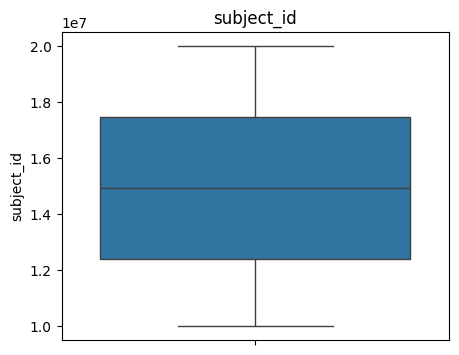

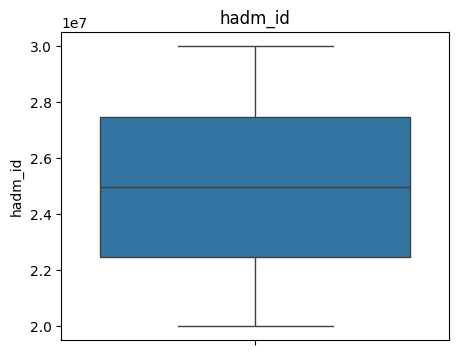

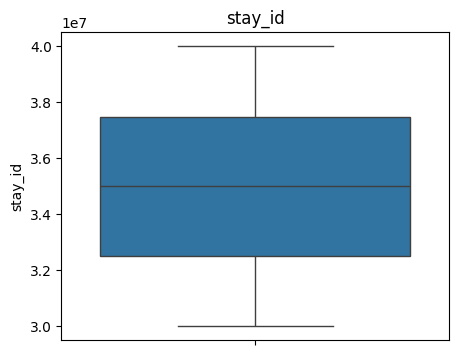

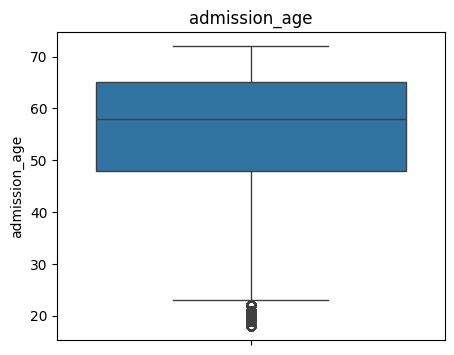

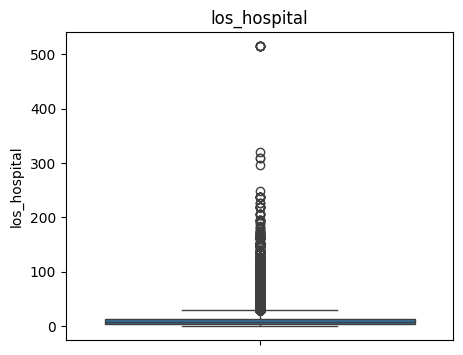

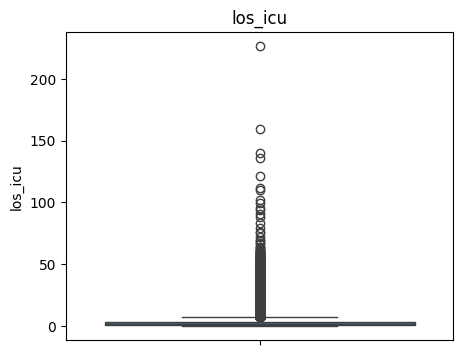

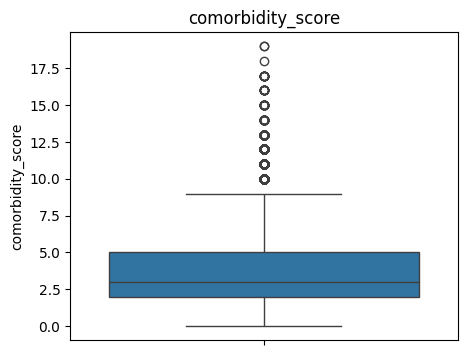

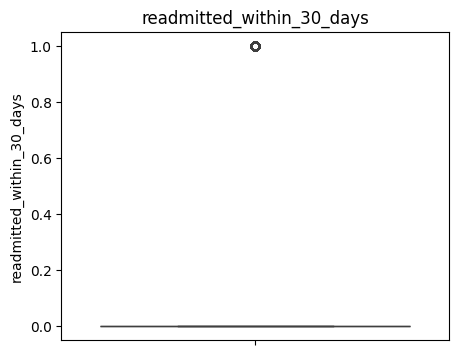

In [9]:
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        plt.figure(figsize=(5,4))
        sns.boxplot(y=df[col])
        plt.title(col)
        plt.show()

In [10]:
df["comorbidity_score"].sort_values(ascending=False).head(30)
# df[df["los_hospital"]>500]
# df["hadm_id"].nunique()
df["comorbidity_score"].describe()
# df

,comorbidity_score
count,53669.000000
mean,3.680505
std,2.717510
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,19.000000


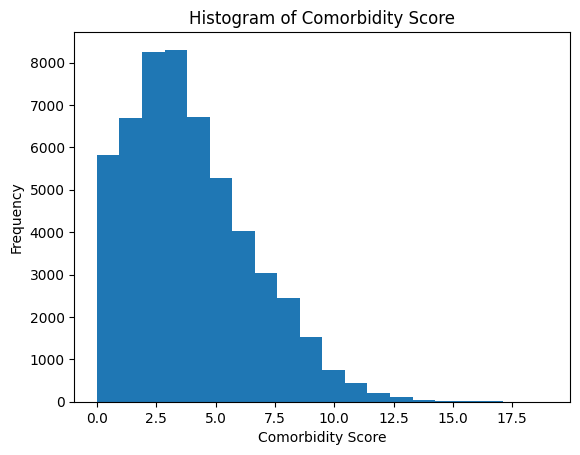

In [11]:
plt.hist(df["comorbidity_score"], bins=20)
plt.xlabel("Comorbidity Score")
plt.ylabel("Frequency")
plt.title("Histogram of Comorbidity Score")
plt.show()


The plot shows that comorbidity scores from about 13(and above) are very rare in our dataset

In [12]:
# df["comorbidity_score"].value_counts().sort_index()
bins=[-1,2,5,8, float('inf')]
# ie (-1-2]=0-2, (2,5]=3-5, (5,8]=6-8
labels=["Low (0-2)", "Moderate (3-5)", "High (6-8)", "Very High (9+)"]
df["comorbidity_group"]=pd.cut(df["comorbidity_score"],bins=bins, labels=labels)
# print(df["comorbidity_group"].value_counts())
df.info()
# df["readmitted_within_30_days"].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 53669 entries, 0 to 53688
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   subject_id                 53669 non-null  int64   
 1   hadm_id                    53669 non-null  int64   
 2   stay_id                    53669 non-null  int64   
 3   admission_age              53669 non-null  int64   
 4   gender                     53669 non-null  object  
 5   race                       53669 non-null  object  
 6   language                   53669 non-null  object  
 7   marital_status             53669 non-null  object  
 8   los_hospital               53669 non-null  int64   
 9   los_icu                    53669 non-null  float64 
 10  first_hosp_stay            53669 non-null  bool    
 11  first_icu_stay             53669 non-null  bool    
 12  comorbidity_score          53669 non-null  int64   
 13  admittime                  53669 non

In [13]:
data_f=df.copy()
data_f.drop(columns=["subject_id","hadm_id","stay_id","admittime", "dischtime"],inplace=True)
data_f["race"].value_counts()


,count
race,
WHITE,32507
OTHER,10998
BLACK/AFRICAN AMERICAN,5614
UNKNOWN,4550


One hot encoding

In [14]:
# data_f.info()
X=data_f.drop(columns="readmitted_within_30_days")
y=data_f["readmitted_within_30_days"]
X.head()
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42,stratify=y_temp)

In [15]:
X_train.shape, X_val.shape, X_test.shape, X_temp.shape

((37568, 12), (8050, 12), (8051, 12), (16101, 12))

Data Preprocessing

In [16]:
cat_cols = X_train.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
])

# Preprocess the data first
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# Use regular SMOTE on the preprocessed data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
print(X_train_resampled.shape)
print(y_train_resampled.shape)
# Train your model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_resampled, y_train_resampled)
# log_model.score(X_train_resampled,y_train)
y_val_pred = log_model.predict(X_val_processed)
# accuracy
print(accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))



(70494, 31)
(70494,)
0.5694409937888198
              precision    recall  f1-score   support

           0       0.96      0.56      0.71      7553
           1       0.09      0.66      0.16       497

    accuracy                           0.57      8050
   macro avg       0.53      0.61      0.44      8050
weighted avg       0.91      0.57      0.68      8050

[[4254 3299]
 [ 167  330]]


In [17]:
# X_train_processed.shape, X_train.shape
# y_train_resampled.shape
log_nosmote=LogisticRegression()
log_nosmote.fit(X_train_processed, y_train)
y_val_pred_nosmote = log_nosmote.predict(X_val_processed)
print("Without SMOTE:")
print(classification_report(y_val, y_val_pred_nosmote))
print(confusion_matrix(y_val, y_val_pred_nosmote))

Without SMOTE:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7553
           1       0.33      0.00      0.00       497

    accuracy                           0.94      8050
   macro avg       0.64      0.50      0.49      8050
weighted avg       0.90      0.94      0.91      8050

[[7551    2]
 [ 496    1]]


In [18]:
import joblib
np.savez("train_data.npz", X_train= X_train_resampled,y_train=y_train_resampled)
np.savez("val_data.npz", X_val=X_val_processed, y_val=y_val)
np.savez("test_data.npz", X_test=X_test, y_test=y_test)


joblib.dump(preprocessor, "preprocessor.pkl")

['preprocessor.pkl']